## SHAP (SHapley Additive exPlanations)

In [64]:
# imports
import shap
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
shap.initjs()
from sklearn.cluster import KMeans
import plotly
import plotly.graph_objs as go
from sklearn.decomposition import PCA

#### Read and process dataset

In [66]:
# Read dataset
dataset = "davidson_dataset"
df = pd.read_pickle('datasets/'+dataset+".pkl")
df.dropna(axis=0, inplace=True)
x = df['text'].values
y = df['label'].values
nltk.download('stopwords')
tfid = TfidfVectorizer(max_features=5000,
                      stop_words = stopwords.words('english'))
x = tfid.fit_transform(x).toarray()
print("class distribution: \n", df['label'].value_counts())
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s164255\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


class distribution: 
 0    3857
1    1376
Name: label, dtype: int64


,index,label,text
0,1,0,as a woman you should not complain about clea...
1,2,0,momma said no cats inside my doghouse
2,3,0,simply addicted to guys hot scally lad
3,4,0,and hot soles
4,5,0,lemmie eat a oreo do these dishes one oreo


#### Train test split

In [4]:
indices = np.random.randint(low=0, high=x.shape[0], size=x.shape[0])
train_indices = indices[0:round(0.5*x.shape[0])]
test_indices = indices[round(0.5*x.shape[0]): x.shape[0]]

In [5]:
df_train = df.ix[train_indices]['text'].values
df_test = df.ix[test_indices]['text'].values
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

C:\Users\s164255\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\s164255\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


#### Model

In [6]:
model = LogisticRegression(C=1, penalty='l1', n_jobs=-1, max_iter=1000)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)


C:\Users\s164255\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s164255\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


(0.9518348623853211, 0.949942682460833)

In [7]:
predictions = model.predict(x_test)

#### SHAP explainer

Refer https://christophm.github.io/interpretable-ml-book/shap.html

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features

We call the SHAP explainer for linear models

In [8]:
explainer = shap.LinearExplainer(model, x_train, feature_dependence="independent")
shap_values = explainer.shap_values(x_test)
shap_values_train = explainer.shap_values(x_train)

feature_dependence:
- independent: breaks any dependence structure between features in the model and so uncover how the model would behave if we intervened and changed some of the inputs (we are interested in this)
 
- dependent: respects correlations among the input features, so if the model depends on one input but that input is correlated with another input, then both get some credit for the model's behavior.

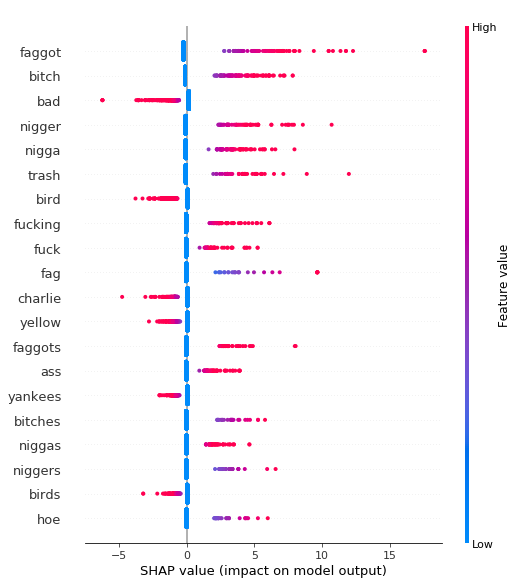

In [9]:
shap.summary_plot(shap_values, x_test, feature_names = tfid.get_feature_names())

This summary plot has features in the order of importance.
Each dot in this plot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction. (faggot causes higher predictions (+ve) where as birds causes lower predictions (-ve))



In [67]:
# Explain a single positive prediction
postive_index = 4
index = np.where(predictions==1)[0][postive_index]
print("text ", df_test[index], " prediction: ", predictions[index], "actual ", y_test[index])
shap.force_plot(explainer.expected_value, shap_values[index,:], x_test[index,:], feature_names = tfid.get_feature_names())

text  i like how niggas try an come at me and im like do it then bitch and they would not do shit pussies  prediction:  1 actual  1


In the force plot shown above, each feature value is a force that either increases or decreases the prediction. The prediction starts from the baseline. The baseline for Shapley values is the average of all predictions. In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance (indicated by output_value)

#### Clustering data

We are going to cluster the training data using kmeans using two methods:
    - using data itself (data space)
    - using shapely values (shapely space)
SHAP clustering works by clustering on Shapley values of each instance. 
This means that you cluster instances by explanation similarity

In [68]:
# Do PCA for scatter plot
pca = PCA(n_components=2, random_state=100)
principals = pca.fit_transform(x_train)

In [38]:
n_clusters = 3

##### SHAP space

In [77]:
km = KMeans(n_clusters=n_clusters)
km.fit(shap_values_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [74]:
data = []
collect = dict()
color = ['hsl(' + str(h) + ',80%' + ',50%)' for h in np.linspace(0, 255, n_clusters)]
for cluster_id in np.unique(km.labels_):
    cluster_indices = np.where(km.labels_ == cluster_id)
    cp = principals[cluster_indices]
    data.append(go.Scatter(x = cp[:,0],
                   y = cp[:,1],
                   mode='markers',                    
                hovertext=df_train[cluster_indices],
                           name = 'cluster '+ str(cluster_id)
                          ))
    collect[cluster_id] = df_train[cluster_indices]
    
fig = go.Figure(data=data)
fig


##### DATA space

In [78]:
km_data = KMeans(n_clusters=n_clusters)
km_data.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [80]:
data = []

for cluster_id in np.unique(km_data.labels_):
    cluster_indices = np.where(km_data.labels_ == cluster_id)
    cp = principals[cluster_indices]
    data.append(go.Scatter(x = cp[:,0],
                   y = cp[:,1],
                   mode='markers',
                hovertext=df_train[cluster_indices],
                name = 'cluster '+ str(cluster_id),
                      
                          ))
fig = go.Figure(data=data)
fig